# Method

In [ ]:
!pip install activeSVC==4.0.1

In [16]:
import numpy as np
import time
import random
import os

from sklearn.preprocessing import normalize 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from matplotlib import gridspec

from activeSVC import min_complexity, min_acquisition
import pandas as pd
import pickle
import os, psutil
import resource

from scipy import io as sio
import seaborn as sns
import matplotlib.ticker as ticker

def text_create(path, name, msg):
    full_path = path + "/" + name + '.pickle'
    f=open(full_path,'wb') 
    pickle.dump(msg,f)
    f.close()

class TimerError(Exception):
     """A custom exception used to report errors in use of Timer class"""

class Timer:
    def __init__(self):
        self._start_time = None

    def start(self):
        if self._start_time is not None:
            raise TimerError(f"Timer is running. Use .stop() to stop it")

        self._start_time = time.perf_counter()

    def stop(self):
        if self._start_time is None:
            raise TimerError(f"Timer is not running. Use .start() to start it")

        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        print(f"Total run time: {elapsed_time:0.4f} seconds")
        return elapsed_time





# Load Data

In [ ]:
import urllib.request
import shutil

try:
    os.mkdir('data')
except OSError:
    print ("Creation of the directory %s failed" % 'data')
else:
    print ("Successfully created the directory %s " % 'data')
    
with urllib.request.urlopen("https://caltech.box.com/shared/static/xbwuzvl0pxocsagd45ag85vqcgplz7ry.pickle") as response, open('./data/tsne.pickle', "wb") as out_file:
    shutil.copyfileobj(response, out_file)

with urllib.request.urlopen("https://caltech.box.com/shared/static/hnnrp9gwuhrle9gslieimr7bpgo3jk4y.csv") as response, open('./data/genes.csv', "wb") as out_file:
    shutil.copyfileobj(response, out_file)

with urllib.request.urlopen("https://caltech.box.com/shared/static/cde2mqnzev8u6ja3eh61c1c8s43udfgl.csv") as response, open('./data/cortex_svz_cellcentroids.csv', "wb") as out_file:
    shutil.copyfileobj(response, out_file)

with urllib.request.urlopen("https://caltech.box.com/shared/static/2kvp1405sccrqatedo084xsu29b4r8ac.csv") as response, open('./data/cortex_svz_counts_cell_types.csv', "wb") as out_file:
    shutil.copyfileobj(response, out_file)


In [2]:
label_df=pd.read_csv('./data/cortex_svz_cellcentroids.csv')
target=label_df['Field of View'].values
raw_data = np.genfromtxt('./data/cortex_svz_counts_cell_types.csv', delimiter=',').transpose()
raw_data[0,0]=3
print(raw_data.shape)
classes=np.unique(target).tolist()
keys=classes
gene=pd.read_csv('./data/genes.csv',header=None)[0].values

x=label_df['X'].values
y=label_df['Y'].values

nonzero_row_indice, _ = raw_data.nonzero()
unique_nonzero_indice = np.unique(nonzero_row_indice)
raw_data=raw_data[unique_nonzero_indice]
target=target[unique_nonzero_indice]
raw_data=raw_data.transpose()
nonzero_row_indice, _ = raw_data.nonzero()
unique_nonzero_indice = np.unique(nonzero_row_indice)
raw_data=raw_data[unique_nonzero_indice]
gene=gene[unique_nonzero_indice]

data=normalize(raw_data.transpose(),axis=1, norm='l2')

idx = np.arange(np.shape(data)[0])
random.shuffle(idx)
X_train = data[idx[:int(np.shape(data)[0]*4/5)],:]
y_train = target[idx[:int(np.shape(data)[0]*4/5)]]
X_test = data[idx[int(np.shape(data)[0]*4/5):],:]
y_test = target[idx[int(np.shape(data)[0]*4/5):]]

del label_df,raw_data,nonzero_row_indice,unique_nonzero_indice

print(type(data))
print(keys)
print(np.shape(data),np.shape(target),len(np.unique(target)))
print(np.shape(X_train))
print(np.shape(X_test))
for i in np.unique(target):
    print(str(i)+' '+ str(keys[i])+': '+str(np.count_nonzero((target==i)*1)))

(913, 10000)
<class 'numpy.ndarray'>
[0, 1, 2, 3, 4, 5, 6]
(913, 10000) (913,) 7
(730, 10000)
(183, 10000)
0 0: 118
1 1: 108
2 2: 90
3 3: 106
4 4: 101
5 5: 281
6 6: 109


# Select Genes and Save Results

Creation of the directory results failed
Creation of the directory results/30genes_10cells failed
Elapsed time: 2.3377 seconds
feature 0 : gene [604]  10 samples
training error=6.884931506849315 test error=6.612021857923497
training accuracy=0.36575342465753424 test accuracy=0.39344262295081966
Elapsed time: 3.0211 seconds
feature 1 : gene 5077  20 samples
training error=6.897260273972603 test error=6.617486338797814
training accuracy=0.363013698630137 test accuracy=0.3879781420765027
Total run time: 5.3717 seconds


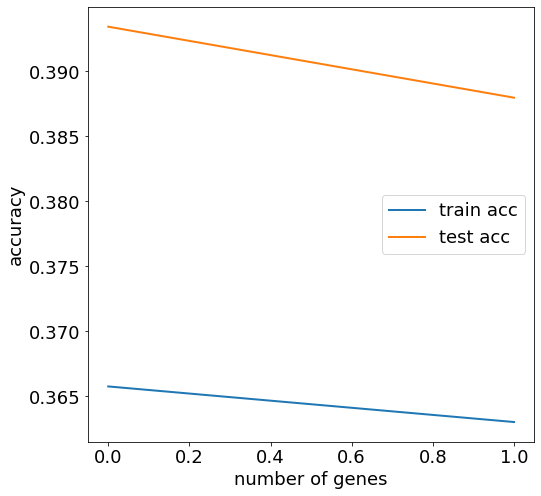

In [3]:
'''
min-complexity random
'''
num_features = 30
num_samples=10
init_samples=10
balance=False

path='results/30genes_10cells'

try:
    os.mkdir('results')
except OSError:
    print ("Creation of the directory %s failed" % 'results')
else:
    print ("Successfully created the directory %s " % 'results')
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)
    
    
if __name__ == '__main__':

    t=Timer()
    t.start()
    feature_selected, num_samples_list, train_errors,test_errors,train_scores,test_scores, step_times= min_complexity(
        X_train,y_train,X_test,y_test,num_features=num_features,num_samples=num_samples,init_samples=init_samples, balance=balance,
        tol=1,C=10, max_iter=1000000,loss='squared_hinge')
    elapsed_time=t.stop()
    
    memorys=[]
    memorys.append(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2)
    memorys.append(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/ 1024 ** 2)
    
    text_create(path,'feature_selected',feature_selected)
    text_create(path,'error',train_errors+test_errors)
    text_create(path,'accuracy',train_scores+test_scores)
    text_create(path,'num_samples_list',num_samples_list)
    text_create(path,'genes_name',gene[feature_selected])
    text_create(path,'elapsed_time',elapsed_time)
    text_create(path,'memory',memorys)

    plt.figure(figsize=(8,8))
    plt.plot(train_scores,linewidth=2)
    plt.plot(test_scores,linewidth=2)
    plt.legend(['train acc','test acc'],prop = {'size':18})
    plt.xlabel('number of genes',fontdict={'weight':'normal','size': 18})
    plt.ylabel('accuracy',fontdict={'weight':'normal','size': 18})
    plt.tick_params(labelsize=18)
    plt.savefig(path+'/acc.pdf', bbox_inches="tight")

feature1=np.copy(feature_selected)

# Plots

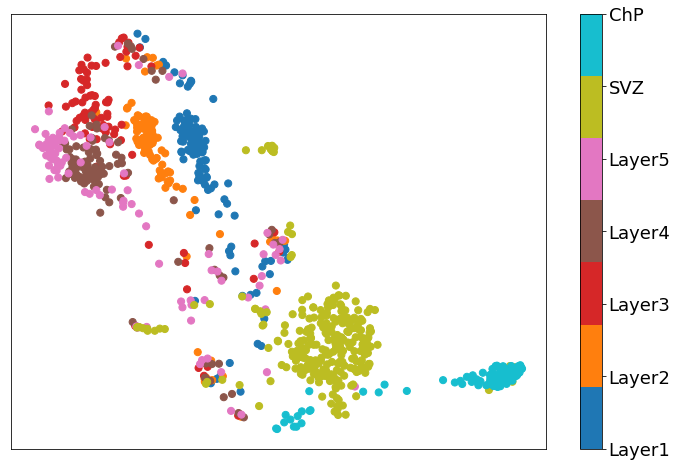

In [7]:
pca=PCA(n_components=20,
       copy=True,
       whiten=False,
       svd_solver='auto',
       tol=0.0,
       iterated_power='auto',
       random_state=None)
pcaproj=pca.fit_transform(data)

Y=TSNE(n_components=2,perplexity=300,early_exaggeration=100).fit_transform(pcaproj)


plt.figure(figsize=(12,8))
c_cmap = plt.get_cmap('tab10', len(classes))
plt.scatter(Y[:,0],Y[:,1],c=target,s=50,cmap=c_cmap)
cbar=plt.colorbar(ticks=np.arange(0,len(classes)))
plt.xticks([])
plt.yticks([])
cbar.ax.set_yticklabels(['Layer1','Layer2','Layer3','Layer4','Layer5','SVZ','ChP'],fontdict={'weight':'normal','size': 18})
plt.savefig(path+'/tsne.pdf',bbox_inches="tight")
import pickle
f=open(path+'/tsne.pickle','wb') 
pickle.dump(Y,f)
f.close()


In [11]:
top=[4732, 185, 218, 8050, 9348, 6844, 4771]
print(gene[top])

['Ltbp4' 'Arc' 'Arnt2' 'Efhd2' 'Wbp2' 'Clstn1' 'Pltp']


/var/folders/r0/dbvfjmts3w92sv4jkxnkbd740000gn/T/ipykernel_9685/2625057831.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['','Layer1','Layer2','Layer3','Layer4','Layer5','SVZ','ChP'],fontdict={'weight':'normal','size': 18,'rotation':45})
/var/folders/r0/dbvfjmts3w92sv4jkxnkbd740000gn/T/ipykernel_9685/2625057831.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['','Layer1','Layer2','Layer3','Layer4','Layer5','SVZ','ChP'],fontdict={'weight':'normal','size': 18,'rotation':45})
/var/folders/r0/dbvfjmts3w92sv4jkxnkbd740000gn/T/ipykernel_9685/2625057831.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['','Layer1','Layer2','Layer3','Layer4','Layer5','SVZ','ChP'],fontdict={'weight':'normal','size': 18,'rotation':45})
/var/folders/r0/dbvfjmts3w92sv4jkxnkbd740000gn/T/ipykernel_9685/2625057831.py:26: UserWarning: FixedFormatter shoul

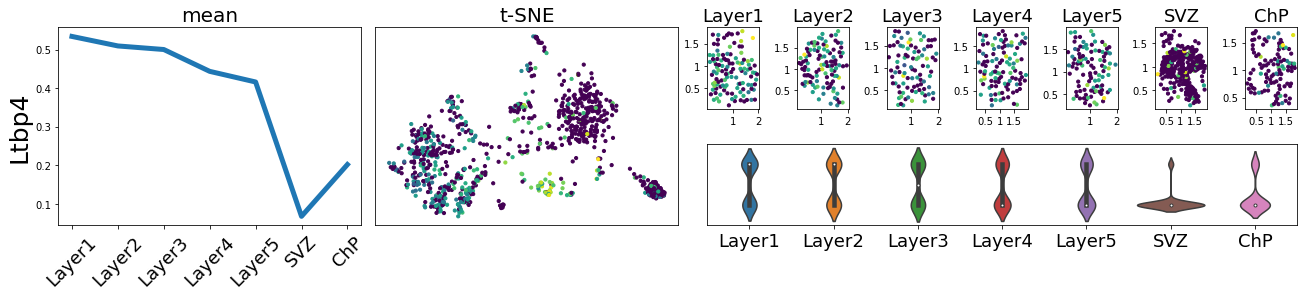

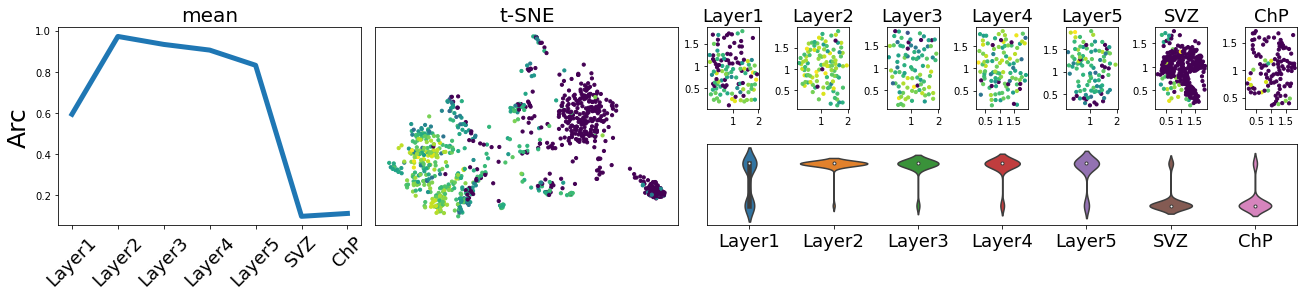

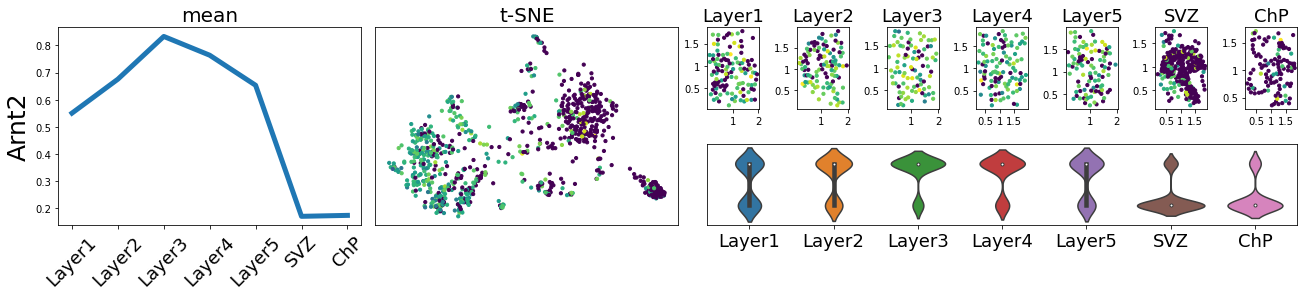

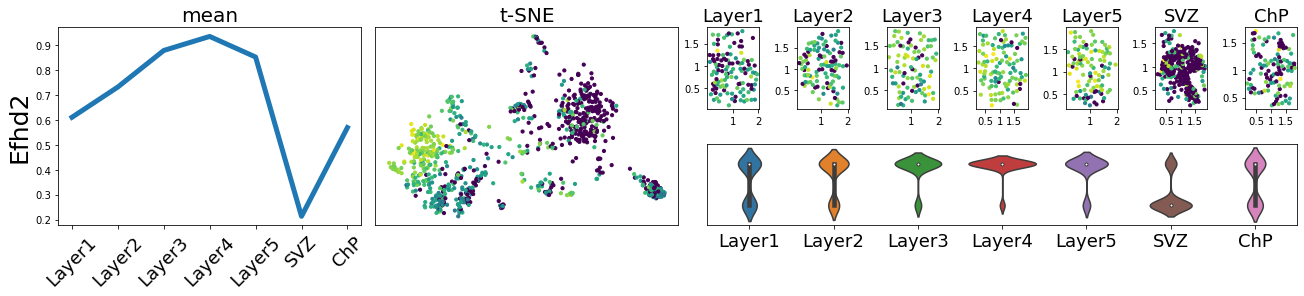

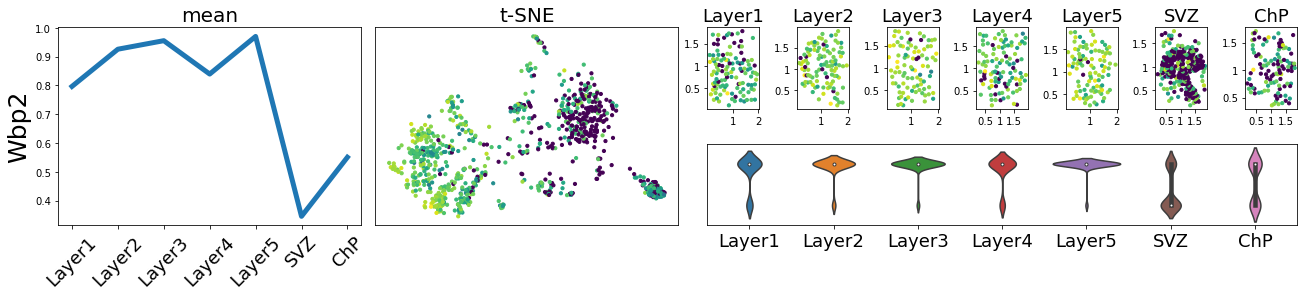

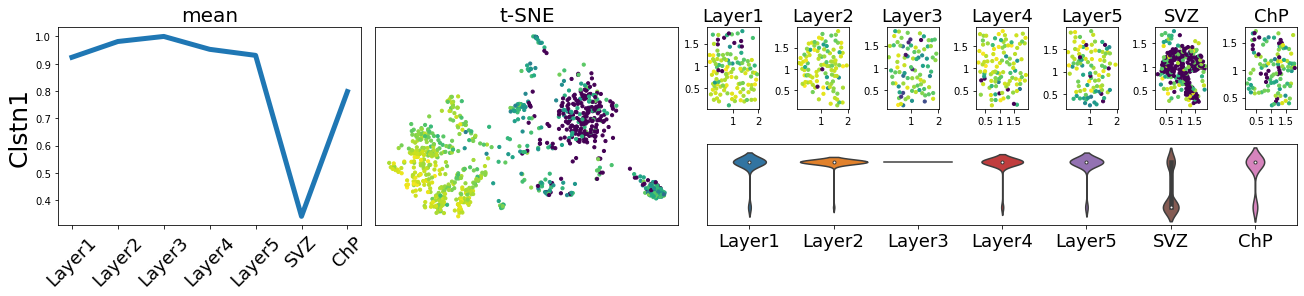

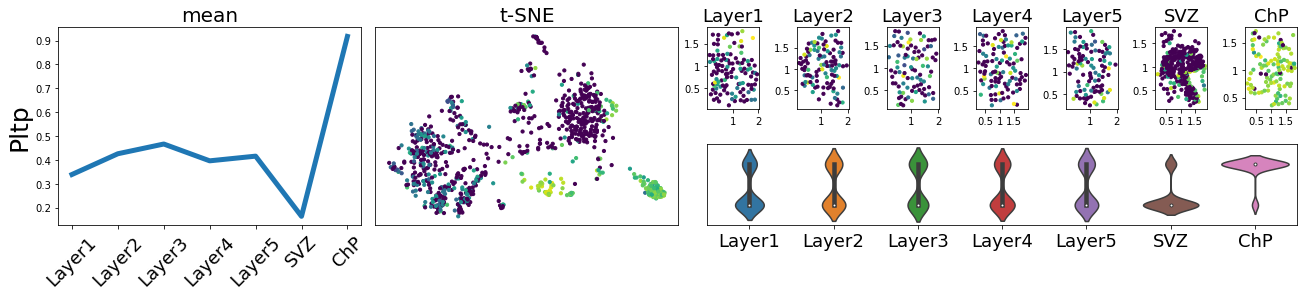

In [17]:
with open('./data/tsne.pickle','rb') as handle:
    Y=pickle.load(handle)
for i in range(len(top)):
    f=top[i]
    fig=plt.figure(constrained_layout=True, figsize=(18,4))
    gs = fig.add_gridspec(2,15)

    alpha = 1000
    num_col=10
    data_show = np.log1p(data*alpha)
    ax0 = plt.subplot(gs[:,4:8])
    ax0.set_title('t-SNE',fontdict={'weight':'normal','size': 20})
    plt.scatter(Y[:,0],Y[:,1],c=data_show[:,f],s=10)
    ax0.set_xticks([])
    ax0.set_yticks([])

    size=7
    s=normalize(data[:,f].reshape(-1, 1),norm='l2')
    mean=[]
    for j in range(size):
        mask=(target==j)
        mean.append(np.mean(s[mask]))
    ax=plt.subplot(gs[:,:4])
    plt.plot(mean,linewidth=5)
    ax.set_ylabel(gene[f],fontdict={'weight':'normal','size': 25})
    ax.set_xticklabels(['','Layer1','Layer2','Layer3','Layer4','Layer5','SVZ','ChP'],fontdict={'weight':'normal','size': 18,'rotation':45})
    ax.set_title('mean',fontdict={'weight':'normal','size': 20})

    l=['Layer1','Layer2','Layer3','Layer4','Layer5','SVZ','ChP']
    for j in range(size):
        idx=np.argwhere(target==j).flatten().tolist()
        ax0=plt.subplot(gs[0,j+8])
        ax0.set_title(l[j],fontdict={'weight':'normal','size': 18})
        plt.scatter(x[idx],y[idx],c=data_show[idx,f],s=10)
        ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/1000))
        ax0.xaxis.set_major_formatter(ticks_x)
        ax0.yaxis.set_major_formatter(ticks_x)

    s=data[:,f]
    s=normalize(data[:,f].reshape(-1, 1),norm='l2')
    violin=[]
    for j in range(size):
        mask=(target==j)
        violin.append(s[mask])
    ax=plt.subplot(gs[1,8:])
    ax = sns.violinplot(data=violin)
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_xticklabels(l,fontdict={'weight':'normal','size': 18})
    plt.savefig(path+'/'+gene[f]+'.pdf',facecolor='white',bbox_inches="tight")
